In [2]:
# Paper 2 - Using the multinomial Nayes bias and svm 
#  Rahul Panwar 20BCS171
#  Adarsh Kumar 20BCS016
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
import re
import nltk
nltk.download('stopwords')
nltk.download("wordnet")
from nltk.corpus import stopwords
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
stop_words = set(stopwords.words("english"))
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [1]:
# So mam here i have mounted the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# I have read the datafile from the drive
df = pd.read_json("/content/drive/MyDrive/Sarcasm_Headlines_Dataset.json",lines=True)
df.head(10)
pd.set_option('display.max_colwidth', -1)

<ipython-input-3-4666b7c0502d>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [4]:
df['source'] = df.article_link.apply(lambda x: x.split('.')[1])
df = df.drop('article_link', axis=1)
df.shape

(26709, 3)

In [5]:
# here we have 14985 non-sarcastic texts and 11724 - sarcastic text
df.is_sarcastic.value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [7]:
print(df.shape)
df.head(100)

(26709, 3)


,headline,is_sarcastic,source
0,former versace store clerk sues over secret 'black code' for minority shoppers,0,huffingtonpost
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0,huffingtonpost
2,mom starting to fear son's web series closest thing she will have to grandchild,1,theonion
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1,theonion
4,j.k. rowling wishes snape happy birthday in the most magical way,0,huffingtonpost
...,...,...,...
95,hunter s. thompson shoots mouth off one last time,1,theonion
96,inhofe's grand climate conspiracy theory: it's all about barbra streisand,0,huffingtonpost
97,5 questions i wish younger people would stop asking me,0,huffingtonpost
98,"albuquerque shooter on the loose; gunman leaves 1 dead, 3 injured",0,huffingtonpost


In [8]:
# here the dataset contains 14985 headlines form huffintonpost and 11724 headlines from theonion
df.source.value_counts()


huffingtonpost    14985
theonion          11724
Name: source, dtype: int64

In [9]:
df.headline.isna().sum()

0

In [10]:
df.describe()

,is_sarcastic
count,26709.000000
mean,0.438953
std,0.496269
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [11]:
cur_stops = [ 'what','which','who','whom','this','that','these','those','been','being','have','has','had','having','do','does','did',
                    'doing','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between',
                    'into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under',
                    'again''further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most',
                    'other','some','such','no','nor','not','only','own','same','so','than','too','very','can','will','just','don','should',
                    'now','n\t' ]

In [12]:
df_gen = df[df['is_sarcastic'] == 0]['headline']
df_sarc = df[df['is_sarcastic'] == 1]['headline']

In [16]:
import nltk

nltk.download('punkt')
# importing the natural language processing kit 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
gen_tokens = df_gen.apply(lambda x: nltk.word_tokenize(x))
sarc_tokens = df_sarc.apply(lambda x: nltk.word_tokenize(x))

In [18]:
gen_dict = {}
sarc_dict = {}
def create_dict(tokens, toks_dict):
    for row in tokens:
        for w in row:
            if w in cur_stops:
                if w in toks_dict:
                    toks_dict[w] += 1
                else:
                    toks_dict[w] = 1
    return toks_dict

gen_count = create_dict(gen_tokens, gen_dict)
sarc_count = create_dict(sarc_tokens, sarc_dict)

In [19]:
df_gen_stops = pd.DataFrame({'Non-sarcasm Stops': list(gen_count.keys()), 
                        'count': list(gen_count.values()) }).sort_values('count', ascending=False).reset_index()
df_sarc_stops = pd.DataFrame({'Sarcasm Stops': list(sarc_count.keys()), 
                        'count': list(sarc_count.values()) }).sort_values('count', ascending=False).reset_index()

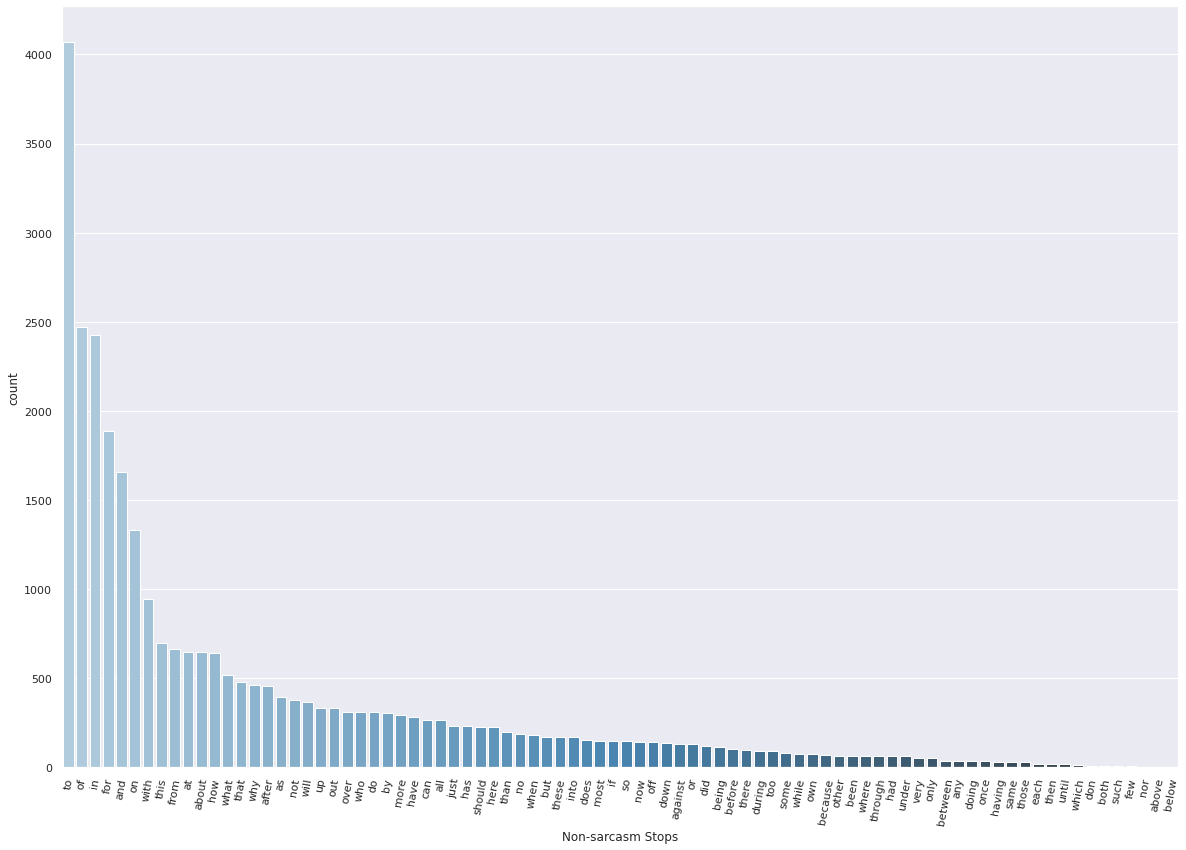

In [20]:
sns.set(rc={'figure.figsize':(20,14)})
a = sns.barplot(x="Non-sarcasm Stops", y='count', data=df_gen_stops, palette="Blues_d")
plt.xticks(rotation=80)
plt.show()
# here the graph shows the words used in the non-sarcastic text most

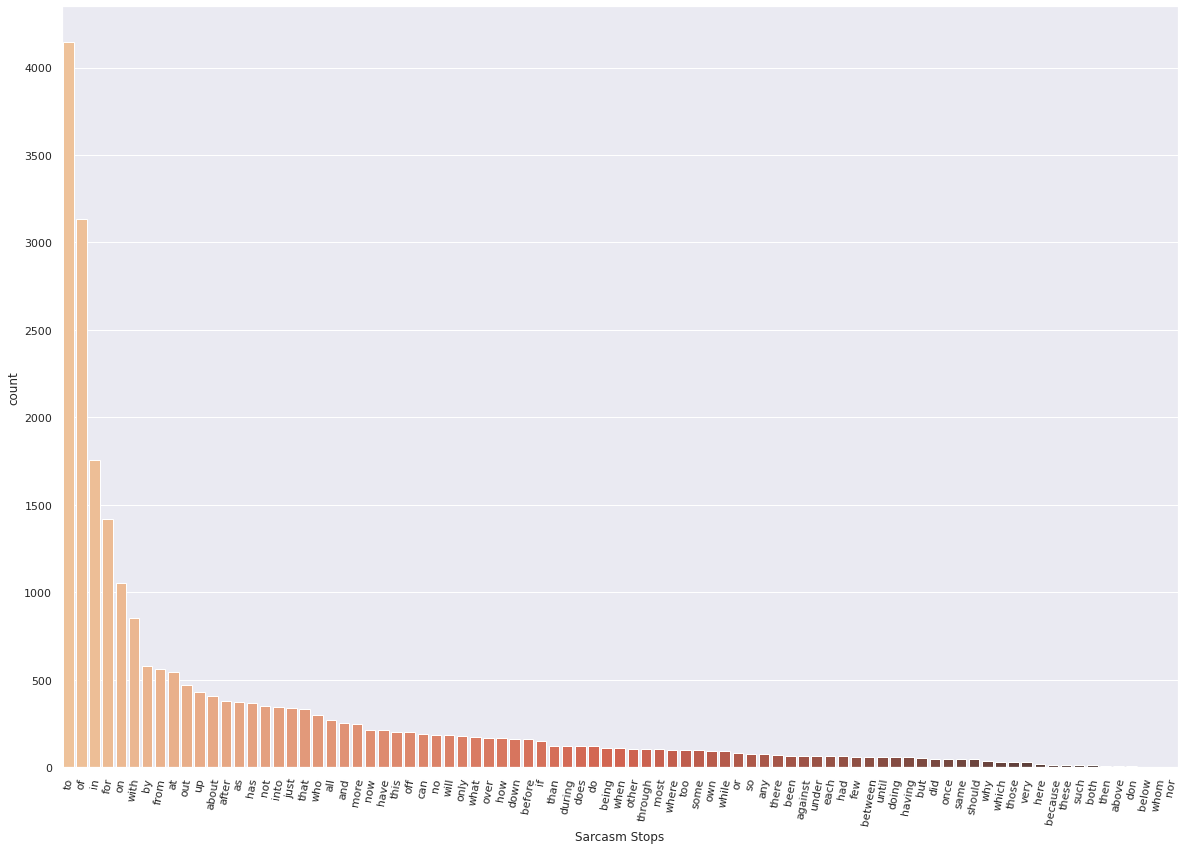

In [21]:
a = sns.barplot(x="Sarcasm Stops", y='count', data=df_sarc_stops, palette="OrRd_d")
plt.xticks(rotation=80)
plt.show()
# here the graph shows the words used in the sarcastic text most

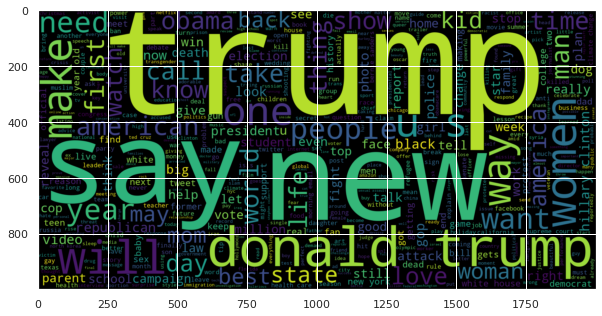

In [22]:
# mam here I have used the wordcloud where the size of the word represents its frequency it has used
plt.figure(figsize = (10,10))
wc = WordCloud(width = 2000 , height = 1000 , max_words = 500).generate(" ".join(df_gen))
plt.imshow(wc , interpolation = 'bilinear')

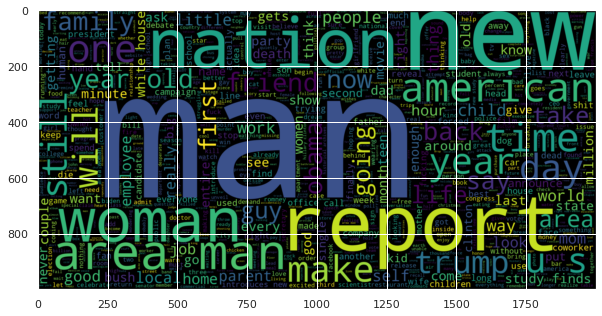

In [23]:
plt.figure(figsize = (10,10))
wc = WordCloud(width = 2000 , height = 1000 , max_words = 1000).generate(" ".join(df_sarc))
plt.imshow(wc , interpolation = 'bilinear')

In [24]:
df['text_len'] = df['headline'].apply(lambda x: len(x.split(' ')))

<Axes: xlabel='is_sarcastic', ylabel='text_len'>

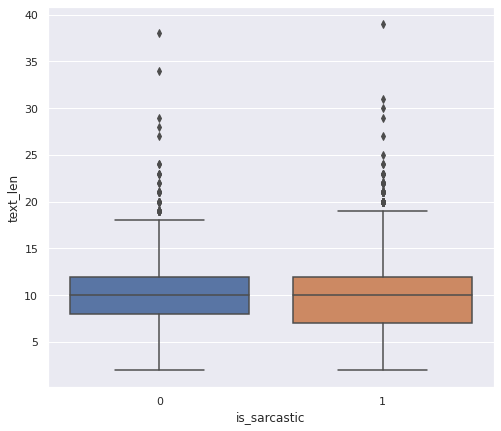

In [25]:
# box plot visualization that shows the distribution of text_len values for the is_sarcastic groups in the df DataFrame
sns.set(rc={'figure.figsize':(8 ,7)})
sns.boxplot(y='text_len', x="is_sarcastic", data=df)

In [27]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

In [29]:
def get_scores(row):
    scores = list()
    h = row.split(' ')
    for word in h:
        score = sia.polarity_scores(word)
        scores.append(score['compound'])
    res = sum(scores) / len(scores)
    return res

df['sentiment_rating'] = df['headline'].apply(lambda x: get_scores(x))

<Axes: xlabel='is_sarcastic', ylabel='sentiment_rating'>

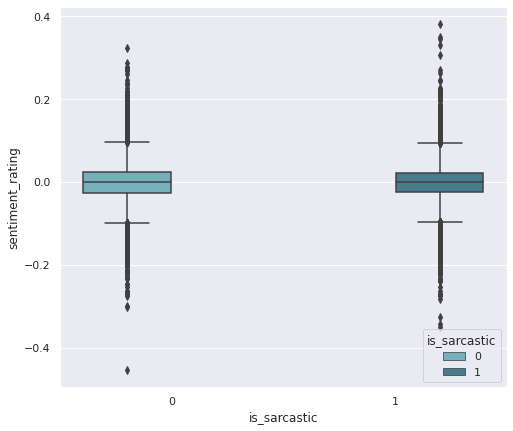

In [30]:
sns.boxplot(y='sentiment_rating', x='is_sarcastic', hue="is_sarcastic", palette="GnBu_d", data=df)

In [31]:
def parser(x):
    x = re.sub('[^a-z\s]', '', x.lower())      
    x = [w for w in x.split() if w not in set(stop_words)]
    x = [w for w in x if wordnet.synsets(w)]
    return ' '.join(x)

df['headline'] = df.headline.apply(lambda x: parser(x))

In [32]:
X = df.drop('is_sarcastic', axis=1)
y = df.is_sarcastic
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:
X_train = X_train['headline']
X_test = X_test['headline']

Mam here 
We will use 2 different vectorizers - CountVectorizer and tf-idf - and see how they perform on the headlines texts.

In [34]:
cv = CountVectorizer(ngram_range=(1,3))
cv_train = cv.fit_transform(X_train)
cv_test = cv.transform(X_test)

print(cv_train.shape)
print(cv_test.shape)

(20031, 193971)
(6678, 193971)


In [35]:
tv = TfidfVectorizer(ngram_range=(1,3))
tv_train = tv.fit_transform(X_train)
tv_test = tv.transform(X_test)

print(tv_train.shape)
print(tv_test.shape)

(20031, 193971)
(6678, 193971)



Mam we have Multinomial Bayes and and SVM to classify our cleaned text data. 

In [36]:
nb = MultinomialNB()

nb_bow_cv = nb.fit(cv_train, y_train)
nb_bow_tv = nb.fit(tv_train, y_train)

In [37]:
nb_cv_predict = nb_bow_cv.predict(cv_test)
nb_tv_predict = nb_bow_tv.predict(tv_test)

In [38]:
nb_cv_score = accuracy_score(y_test, nb_cv_predict)
nb_tv_score = accuracy_score(y_test, nb_tv_predict)
print(nb_cv_score, nb_tv_score)

0.7845163222521713 0.7638514525306979


In [39]:
cm_cv = confusion_matrix(y_test,nb_cv_predict)
cm_tv = confusion_matrix(y_test, nb_tv_predict)

<Axes: >

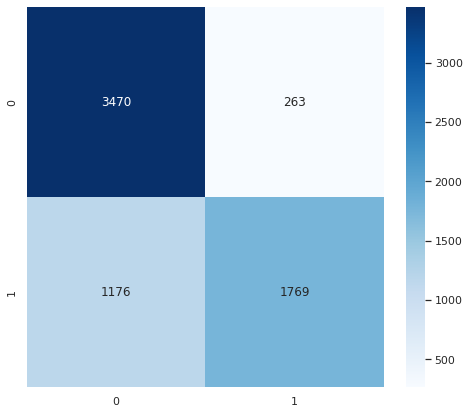

In [40]:
df_cv = pd.DataFrame(cm_cv)
df_tv = pd.DataFrame(cm_tv)

sns.heatmap(cm_cv, cmap='Blues',annot = True, fmt='')

<Axes: >

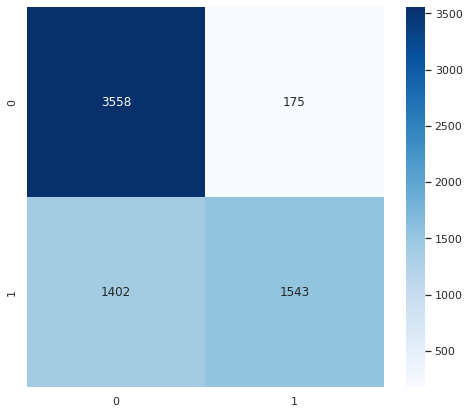

In [41]:
sns.heatmap(cm_tv, cmap='Blues',annot = True, fmt='')

In [42]:
df_samp = df.sample(n=2000)
X_train_samp, X_test_samp, y_train_samp, y_test_samp = train_test_split(df_samp.drop('is_sarcastic', axis=1), df_samp.is_sarcastic)

cv = CountVectorizer(ngram_range=(1,3))
cv_train_samp = cv.fit_transform(X_train_samp.headline)
cv_test_samp = cv.transform(X_test_samp.headline)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

parameters = { 'loss': ('hinge', 'log', 'modified_huber'), 'penalty': ('l1', 'l2', 'elasticnet',), 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}

sgd = SGDClassifier()
clf = GridSearchCV(sgd, parameters)
clf.fit(cv_train_samp, y_train_samp)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/l

GridSearchCV(estimator=SGDClassifier(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'loss': ('hinge', 'log', 'modified_huber'),
                         'penalty': ('l1', 'l2', 'elasticnet')})

In [43]:
print(clf.best_estimator_, clf.best_score_, clf.best_params_)

SGDClassifier(loss='log') 0.7113333333333334 {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}
